<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Categorize German News Articles

Christph Fahrni, based on BERT-Exercise by Joel Akeret and Fabian Märki

## ToC
- Access the [Ten Thousand German News Articles Dataset](https://tblock.github.io/10kGNAD/)
- Preprocess data
  - Shortcut: try to download preprocessed data. If failed, run preprocess routines below:
    - Data inspection: Analyze distribution of labels of training/testdata
    - Labels: One hot encoding
    - Article: Clean text, BertTokenizer
    - Save preprocessed data
- Neural Netwerk:
  - InputLayer: word_ids, length=192
  - TFBertModel (last_hidden_state>cls_embedding)
  - Dropout 10%
  - Dense
  - OutputLayer after softmax activation: 9 classes
- Experiment 1: Overfit
  - Uses only first 128 datasets
  - TFBertModel: Freeze weights
- Experiment 2: AllData
  - Uses 95% of training datasets to train, 5% to validate
  - TFBertModel: Freeze weights
- Experiment 3: FineTune
  - Uses 95% of training datasets to train, 5% to validate
  - Train all weights with low learningRate
- Evaluation
  - Inference test data
  - Confusion matrix
  - Scores

# Summary
Predict one of the 9 categories of German news articles.
Categories are: Etat, Inland, International, Kultur, Panorama, Sport, Web, Wirtschaft, Wissenschaft.

The f1-score of 0.89 (average) is reached. On the category sport, the f1-score is 0.98. The reason could be that the vocabulary differs more from other categories.

## Links
<a href="https://colab.research.google.com/github/chrisfahrni/2023_HS_DAS_NLP_Notebooks/blob/master/projekt/bert/German_News_Article_Dropout.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
# Check GPU configuration
# Note: Use multi GPUs using tf.distribute.MirroredStrategy()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15549149255837735170
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23295819776
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 3259180746407971041
physical_device_desc: "device: 0, name: NVIDIA A30, pci bus id: 0000:3b:00.0, compute capability: 8.0"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23295819776
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 2350567193504813647
physical_device_desc: "device: 1, name: NVIDIA A30, pci bus id: 0000:af:00.0, compute capability: 8.0"
xla_global_id: 2144165316
, 

2023-10-19 17:45:41.713126: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-19 17:45:43.938172: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-19 17:45:43.938242: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 22216 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:3b:00.0, compute capability: 8.0
2023-10-19 17:45:43.939923: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Origin

In [3]:
import sys
import os
import pandas as pd
import numpy as np

in_colab = 'google.colab' in sys.modules
if in_colab:
    from google.colab import drive
    mountPath = '/content/drive'
    if not os.path.ismount(mountPath):
      drive.mount(mountPath)
    path_data = mountPath + "/MyDrive/Colab Notebooks/FHNW CAS-DL/Advanced NLP/projekt/"
    os.chdir(path_data)
else:
    path_data = "."

!ls

skip_preprocessing = False
try:
  X_train = np.load('data/X_train.npy')
  X_test = np.load('data/X_test.npy')
  y_train = np.load('data/y_train.npy')
  y_test = np.load('data/y_test.npy')
  labels = np.load('data/classes.npy')
  skip_preprocessing = True
  print("Preprocessing already done")
except:
  print("Run preprocessing")

'German_News_Article_Dropout copy.ipynb'   data     nlp-gpu.yml
 German_News_Article_Fasttext.ipynb	   env	    requirements.txt
 archive				   models   sharedfiles
Run preprocessing


In [4]:
%%capture
from fhnw.nlp.utils.ploting import plot_history
!pip install -U transformers==4.34.0 # latet version from 3.10.

if not skip_preprocessing:
  !pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

  from fhnw.nlp.utils.processing import parallelize_dataframe
  from fhnw.nlp.utils.processing import is_iterable
  from fhnw.nlp.utils.storage import download
  from fhnw.nlp.utils.storage import save_dataframe
  from fhnw.nlp.utils.storage import load_dataframe

We recommend to use the stratified train/test split proposed by the maintainer of the dataset.

In [5]:
def load_data():
  file = "data/german_news_articles_original_train.parq"
  download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
  data_train = load_dataframe(file)

  file = "data/german_news_articles_original_test.parq"
  download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
  data_test = load_dataframe(file)

  return data_train, data_test

Get a first impression...

In [6]:
if not skip_preprocessing:
  data_train, data_test = load_data()
  data_train["split"] = "train"
  data_test["split"] = "test"
  print('data_train:', data_train.shape)
  print('data_test: ', data_test.shape)
  print(data_train.head(3))

data_train: (9245, 3)
data_test:  (1028, 3)
                                       text_original   label  split
0  21-Jähriger fällt wohl bis Saisonende aus. Wie...   Sport  train
1  Erfundene Bilder zu Filmen, die als verloren g...  Kultur  train
2  Der frischgekürte CEO Sundar Pichai setzt auf ...     Web  train


# Data inspection

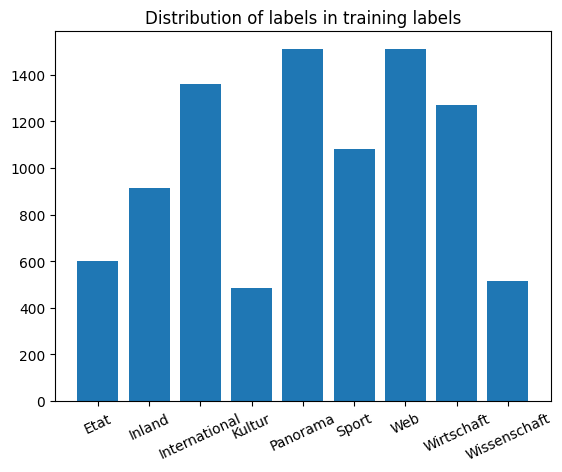

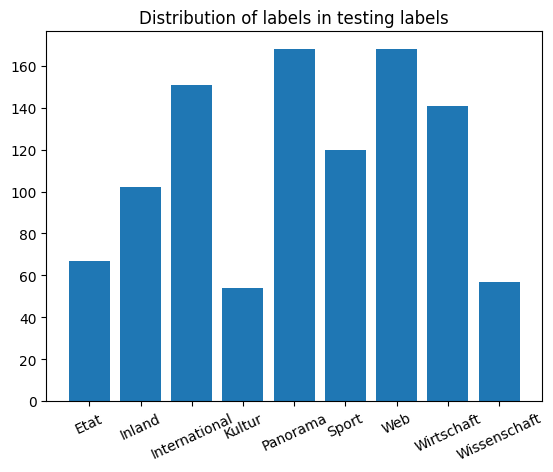

In [7]:
if not skip_preprocessing:
  from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
  import matplotlib.pyplot as plt

  # Analyze Train labels
  labels_train = data_train[['label']]
  enc_ord = OrdinalEncoder()
  labels_train_ord = enc_ord.fit_transform(labels_train)

  label_classes = enc_ord.categories_
  num_distinct_classes = [len(classes) for classes in label_classes][0]
  categories_str = [str(category) for category in label_classes[0]]
  np.save('data/classes.npy', categories_str)

  bins = np.bincount(labels_train_ord.flatten().astype('int'))
  fig, ax = plt.subplots()
  ax.bar(categories_str, bins)
  plt.xticks(rotation=25)
  plt.title("Distribution of labels in training labels")
  plt.show()

  # Analyze Test labels
  labels_test = data_test[['label']]
  labels_test_ord = enc_ord.transform(labels_test)

  bins = np.bincount(labels_test_ord.flatten().astype('int'))
  ffig, ax = plt.subplots()
  ax.bar(categories_str, bins)
  plt.xticks(rotation=25)
  plt.title("Distribution of labels in testing labels")
  plt.show()

Articles 'Etat', 'Kultur' und 'Wissenschaft' are less representative.
Distribution of train- und test-datasets are similar.

In [8]:
# One hot encode and save labels
if not skip_preprocessing:
  enc_1hot = OneHotEncoder()
  labels_train_1hot = enc_1hot.fit_transform(labels_train_ord)
  labels_test_1hot = enc_1hot.fit_transform(labels_test_ord)
  y_train = labels_train_1hot.toarray()
  y_test = labels_test_1hot.toarray()

  os.chdir(path_data)
  np.save('data/y_train.npy', y_train)
  np.save('data/y_test.npy', y_test)

In [9]:
# Clean text
import re

RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
RE_TAGS = re.compile(r"<[^>]+>")
RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

def clean_text(text):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
    """

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)
    return text

if not skip_preprocessing:
  data_train_clean = data_train["text_original"].map(clean_text)
  data_test_clean = data_test["text_original"].map(clean_text)
  print([data_train["text_original"].head(8), data_train_clean.head(8)])

[0    21-Jähriger fällt wohl bis Saisonende aus. Wie...
1    Erfundene Bilder zu Filmen, die als verloren g...
2    Der frischgekürte CEO Sundar Pichai setzt auf ...
3    Putin: "Einigung, dass wir Menge auf Niveau vo...
4    Estland sieht den künftigen österreichischen P...
5    Der Welser Stempelhersteller verbreitert sich ...
6    Traditionsklub setzt sich gegen den FC Utrecht...
7    Finanzausschuss tagte Montag: Konfliktthemen S...
Name: text_original, dtype: object, 0     Jähriger fällt wohl bis Saisonende aus. Wien ...
1    Erfundene Bilder zu Filmen, die als verloren g...
2    Der frischgekürte CEO Sundar Pichai setzt auf ...
3    Putin Einigung, dass wir Menge auf Niveau von ...
4    Estland sieht den künftigen österreichischen P...
5    Der Welser Stempelhersteller verbreitert sich ...
6    Traditionsklub setzt sich gegen den FC Utrecht...
7    Finanzausschuss tagte Montag Konfliktthemen St...
Name: text_original, dtype: object]


In [11]:
from pathlib import Path

fasttextModel = 'sharedfiles/fasttext/cc.de.300.bin'
if not Path(fasttextModel).exists():
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.de.300.bin.gz
    print('unizp')
    !gunzip cc.de.300.bin.gz
    print('done')
    !mkdir -p sharedfiles/fasttext
    !mv cc.de.300.bin sharedfiles/fasttext/

In [12]:
#!pip install fasttext
import fasttext

ft = fasttext.load_model(fasttextModel)

In [13]:
# Test
print (len(ft["Guten Tag"]))

300


In [14]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words("german"))

[nltk_data] Downloading package stopwords to /home/lcfa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
import tqdm
from nltk.tokenize import wordpunct_tokenize

if not skip_preprocessing:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

MAX_LEN = 256
def tokenize(text):
  word_tokens = wordpunct_tokenize(text)[:MAX_LEN]
  tokens = [ft[word] for word in word_tokens if word.lower() not in stopwords]
  return np.array(tokens)

if not skip_preprocessing:
  X_train = np.array([tokenize(article) for article in tqdm.tqdm(data_train_clean)])#[..., np.newaxis]
  X_test = np.array([tokenize(article) for article in tqdm.tqdm(data_test_clean)])#[..., np.newaxis]
  print ('train: ', X_train.shape)
  print ('test:  ', X_test.shape)

# Save preprocessed tokens
  os.chdir(path_data)
  np.save('data/X_train.npy', X_train)
  np.save('data/X_test.npy', X_test)

100%|██████████| 9245/9245 [00:13<00:00, 662.80it/s]
/tmp/ipykernel_2476567/673073392.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array([tokenize(article) for article in tqdm.tqdm(data_train_clean)])#[..., np.newaxis]
100%|██████████| 1028/1028 [00:01<00:00, 699.81it/s]
/tmp/ipykernel_2476567/673073392.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array([tokenize(article) for article in tqdm.tqdm(data_test_clean)])#[..., np.newaxis]


train:  (9245,)
test:   (1028,)


In [30]:
print(len(X_train[0]))
print(len(X_train[1]))

47
165


In [68]:
import tensorflow as tf
from tensorflow import keras

def build_model():
    embeddings = 300
    rnn_units=32
    output_classes = 9
    # Build a separate model for training
    model = keras.Sequential(name="rnn_train")
    # The input for the training model is already processes, i.e. vectorized.
    # Offloading this step and prefetching the data provides speedup during training
    # After vectorization we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(keras.Input(shape=(None,300), dtype=tf.float32, name="preprocessed_input", ragged=True))

    model.add(keras.layers.Bidirectional(
        keras.layers.LSTM(rnn_units, return_sequences=True)
    ))
    model.add(keras.layers.GlobalMaxPool1D(name="global_max_pool"))
    
    # an alternative
    # model_train.add(keras.layers.GlobalAveragePooling1D(name="global_average_pool"))
    # another alternative (but ensure fixed time dimension by setting TextVectorization.output_sequence_length and Embedding.input_length)
    # model_train.add(keras.layers.Flatten(name="flatten"))
    # model_train.add(keras.layers.Dense(100, activation="relu", name="dense"))

    # do not forget Dropout (regularization) for a more sophisticated model

    # add the classification head

    model.add(keras.layers.Dropout(0.1))
    # model.add(keras.layers.Dense(output_classes*2, activation='relu'))
    model.add(keras.layers.Dense(output_classes, activation='softmax', name="prediction"))

    return model

model = build_model()
model.summary()

path_model = path_data + '/models/'

Model: "rnn_train"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, None, 64)         85248     
 nal)                                                            
                                                                 
 global_max_pool (GlobalMaxP  (None, 64)               0         
 ooling1D)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 prediction (Dense)          (None, 9)                 585       
                                                                 
Total params: 85,833
Trainable params: 85,833
Non-trainable params: 0
_________________________________________________________________


# Experiment 1: Overfit
- Uses only first 128 datasets
- TFBertModel: Freeze weights

In [89]:
# Overfit
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = "categorical_crossentropy"

model.compile(optimizer, loss=loss, metrics=["accuracy"]) # colab: , jit_compile=True

In [91]:
# create a validation data set with 5% of data
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42, stratify=y_train)

X_ = X[:4*BATCH_SIZE]
y_ = y[:4*BATCH_SIZE]

# Create a tf.data.Dataset
ragged_embeddings = tf.ragged.constant(X_, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((ragged_embeddings, y_))

train_dataset = (tf.data.Dataset.from_tensor_slices((ragged_embeddings, y_))
                    .shuffle(buffer_size=len(X_), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))

ragged_embeddings_val = tf.ragged.constant(X_val, dtype=tf.float32)
val_dataset = (tf.data.Dataset.from_tensor_slices((ragged_embeddings_val, y_val))
                    .batch(BATCH_SIZE))


In [92]:
checkpoint_path=path_model + 'model_v2_overfit'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist_overfit = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=int(np.floor((len(X_) / BATCH_SIZE))),
    validation_data=val_dataset,
    verbose=1,
    callbacks=[
               #tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=1, restore_best_weights=True),
               model_checkpoint_callback
               #tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)

Epoch 1/20
4/4 [==============================] - 5s 952ms/step - loss: 0.5524 - accuracy: 0.8594 - val_loss: 1.4911 - val_accuracy: 0.5313
Epoch 2/20
4/4 [==============================] - 3s 798ms/step - loss: 0.6527 - accuracy: 0.7891 - val_loss: 1.5561 - val_accuracy: 0.5162
Epoch 3/20
4/4 [==============================] - 3s 803ms/step - loss: 0.6448 - accuracy: 0.8047 - val_loss: 1.5196 - val_accuracy: 0.5378
Epoch 4/20
4/4 [==============================] - 3s 756ms/step - loss: 0.4145 - accuracy: 0.9141 - val_loss: 1.6644 - val_accuracy: 0.5076
Epoch 5/20
4/4 [==============================] - 3s 850ms/step - loss: 0.4002 - accuracy: 0.9141 - val_loss: 1.5803 - val_accuracy: 0.5378
Epoch 6/20
4/4 [==============================] - 3s 768ms/step - loss: 0.3722 - accuracy: 0.9297 - val_loss: 1.4134 - val_accuracy: 0.5724
Epoch 7/20
4/4 [==============================] - 3s 912ms/step - loss: 0.4567 - accuracy: 0.8828 - val_loss: 1.4525 - val_accuracy: 0.5400
Epoch 8/20
4/4 [====

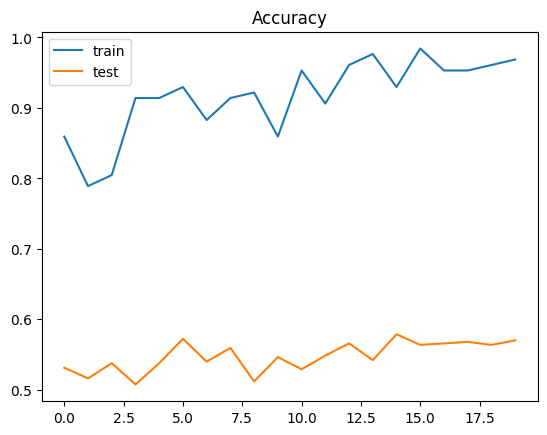

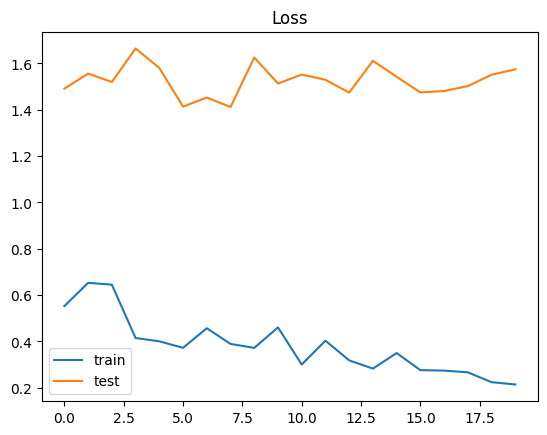

In [93]:
plot_history(hist_overfit)

Reaches Accuracy of ~100%, performs worse on validation data.

# Experiment 2: AllData
- Uses 95% of training datasets to train, 5% to validate
- create a new model

In [162]:
BATCH_SIZE = 64
EPOCHS = 40
LEARNING_RATE = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = "categorical_crossentropy"

model = build_model()
model.compile(optimizer, loss=loss, metrics=["accuracy"]) # colab: , jit_compile=True

model.summary()

# create a validation data set with 5% of data
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42, stratify=y_train)

X_ = X
y_ = y
#ragged_embeddings = tf.ragged.constant(X_, dtype=tf.float32)
'''
dataset = tf.data.Dataset.from_tensor_slices((ragged_embeddings, y_))

train_dataset = (tf.data.Dataset.from_tensor_slices((ragged_embeddings, y_))
                    # .shuffle(buffer_size=len(X_), reshuffle_each_iteration=True)
                    .repeat(1)
                    .batch(BATCH_SIZE))
'''
ragged_embeddings_val = tf.ragged.constant(X_val, dtype=tf.float32)
val_dataset = (tf.data.Dataset.from_tensor_slices((ragged_embeddings_val, y_val))
                    .batch(BATCH_SIZE))

Model: "rnn_train"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, None, 64)         85248     
 onal)                                                           
                                                                 
 global_max_pool (GlobalMaxP  (None, 64)               0         
 ooling1D)                                                       
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 prediction (Dense)          (None, 9)                 585       
                                                                 
Total params: 85,833
Trainable params: 85,833
Non-trainable params: 0
_________________________________________________________________


In [163]:
#ragged_embeddings = tf.ragged.constant(X_) 
max_length = max(len(embedding) for embedding in X_)


# Pad the embeddings to the maximum length
padded_embeddings = [np.resize(embedding, max_length) for embedding in X_]


print(len(padded_embeddings[0] ))
print(padded_embeddings[0] )
print(len(padded_embeddings[1] ))
print((padded_embeddings[1].shape ))

train_dataset = (tf.data.Dataset.from_tensor_slices((padded_embeddings, y_))
                    .shuffle(buffer_size=len(train_dataset), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))
#x_train1 = tf.keras.preprocessing.sequence.pad_sequences(X_, maxlen=max_length, padding='post')

214
(214,)
214
(214,)


In [165]:
print(len(padded_embeddings[0] ))

214


In [161]:
checkpoint_path=path_model + "model_v2_allData"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist_allData = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    # steps_per_epoch=int(np.floor((len(X_) / BATCH_SIZE))),
    shuffle = True,
    #validation_data=val_dataset,
    verbose=1,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=2, restore_best_weights=True),
               model_checkpoint_callback
               #tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)

Epoch 1/40


ValueError: in user code:

    File "/home/lcfa/nlp/env/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/lcfa/nlp/env/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lcfa/nlp/env/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/lcfa/nlp/env/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/lcfa/nlp/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/lcfa/nlp/env/lib/python3.8/site-packages/keras/engine/input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "rnn_train" (type Sequential).
    
    Input 0 of layer "bidirectional_11" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 214)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 214), dtype=float32)
      • training=True
      • mask=None


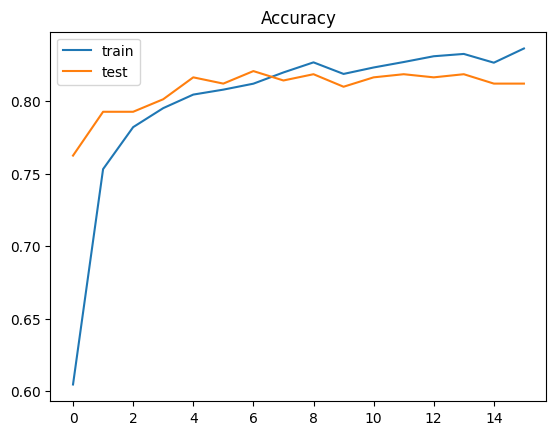

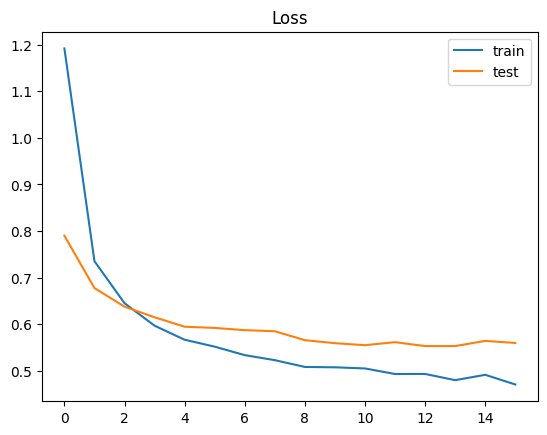

In [75]:
plot_history(hist_allData)

Validation accuracy of 81%

# Experiment 3: FineTune
- Uses 95% of training datasets to train, 5% to validate
- Train all weights with low learningRate

In [76]:
model.get_layer("model_bert").trainable = True
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 192)]            0         
                                                                 
 model_bert (TFBertModel)    TFBaseModelOutputWithPoo  109081344 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             192, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [90]:
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 1e-6

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss ="categorical_crossentropy"

model.load_weights(path_model + "model_v2_allData", skip_mismatch=False, by_name=False, options=None)
model.compile(optimizer, loss=loss, metrics=["accuracy"]) # colab: , jit_compile=True

In [91]:
checkpoint_path=path_model + "model_v2_fine"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist_fine = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=int(np.floor((len(X_) / BATCH_SIZE))),
    validation_data=val_dataset,
    verbose=1,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=3, restore_best_weights=True),
               model_checkpoint_callback
               #tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)

Epoch 1/50
68/68 [==============================] - 49s 560ms/step - loss: 0.4480 - accuracy: 0.8428 - val_loss: 0.4774 - val_accuracy: 0.8359
Epoch 2/50
68/68 [==============================] - 36s 526ms/step - loss: 0.4009 - accuracy: 0.8552 - val_loss: 0.4582 - val_accuracy: 0.8467
Epoch 3/50
68/68 [==============================] - 36s 526ms/step - loss: 0.3735 - accuracy: 0.8674 - val_loss: 0.4438 - val_accuracy: 0.8488
Epoch 4/50
68/68 [==============================] - 36s 525ms/step - loss: 0.3654 - accuracy: 0.8745 - val_loss: 0.4421 - val_accuracy: 0.8531
Epoch 5/50
68/68 [==============================] - 36s 526ms/step - loss: 0.3343 - accuracy: 0.8830 - val_loss: 0.4273 - val_accuracy: 0.8596
Epoch 6/50
68/68 [==============================] - 33s 484ms/step - loss: 0.3442 - accuracy: 0.8812 - val_loss: 0.4282 - val_accuracy: 0.8575
Epoch 7/50
68/68 [==============================] - 36s 527ms/step - loss: 0.3189 - accuracy: 0.8874 - val_loss: 0.4251 - val_accuracy: 0.8531

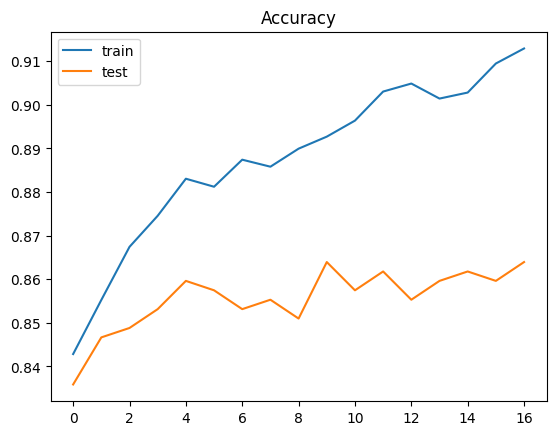

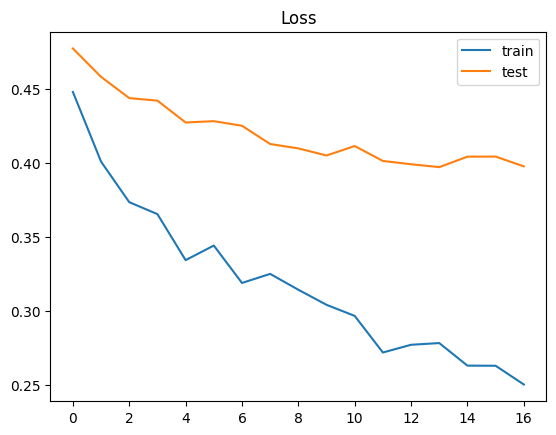

In [92]:
plot_history(hist_fine)

# Evaluation

In [93]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

accuracy_score(y_test_class, y_pred_class)

cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)
print(labels)

[[ 48   5   1   5   1   0   4   3   0]
 [  1  89   3   2   3   0   0   3   1]
 [  0   1 134   0  10   1   1   4   0]
 [  1   1   1  47   2   0   1   0   1]
 [  1   8  12   2 136   0   1   5   3]
 [  0   0   0   0   3 117   0   0   0]
 [  2   2   2   1   0   0 160   1   0]
 [  0   5   1   0   7   0   2 126   0]
 [  0   1   2   0   2   0   0   3  49]]
['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
CPU times: user 4.46 s, sys: 322 ms, total: 4.78 s
Wall time: 5.01 s


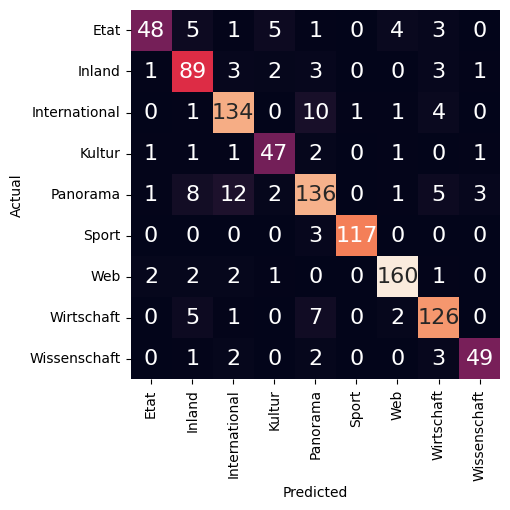

               precision    recall  f1-score   support

         Etat       0.91      0.72      0.80        67
       Inland       0.79      0.87      0.83       102
International       0.86      0.89      0.87       151
       Kultur       0.82      0.87      0.85        54
     Panorama       0.83      0.81      0.82       168
        Sport       0.99      0.97      0.98       120
          Web       0.95      0.95      0.95       168
   Wirtschaft       0.87      0.89      0.88       141
 Wissenschaft       0.91      0.86      0.88        57

     accuracy                           0.88      1028
    macro avg       0.88      0.87      0.87      1028
 weighted avg       0.88      0.88      0.88      1028



In [94]:
import seaborn as sn

df_cm = pd.DataFrame(cm, labels, labels)
ax = sn.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#ax.invert_yaxis() #optional
plt.show()

from sklearn.metrics import classification_report

print(classification_report(y_test_class, y_pred_class, target_names=labels))